# Game Classifier

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

In [2]:
from functools import partial

import requests
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastcore.all import *
from fastprogress.fastprogress import progress_bar
from torch.nn import functional as F

In [15]:
INPUT_DIR = Path("/kaggle/input" if iskaggle else '.')
OUTPUT_DIR = Path("/kaggle/working" if iskaggle else '.')

DATA_DIR = INPUT_DIR / "images/classifier"
TRAIN_DIR = DATA_DIR / "train"
VALID_DIR = DATA_DIR / "valid"

PLATFORMS = ["NES", "SNES", "Nintendo 64", "Game Boy",
             "Game Boy Color", "Game Boy Advance", "Nintendo DS", "Nintendo 3DS"]

## Gathering Data

### Moby API

In [4]:
from dotenv import load_dotenv

load_dotenv()

MOBY_API_URL = "https://api.mobygames.com/v1"
MOBY_API_KEY = os.getenv('MOBY_API_KEY')

In [ ]:
def get_platform_ids():
    params = {'api_key': MOBY_API_KEY}
    response = requests.get(f"{MOBY_API_URL}/platforms", params)
    if response.status_code == 200:
        response = response.json()
        return {platform['platform_name']: platform['platform_id']
                for platform in response['platforms']}
    else:
        raise Exception(f"Failed to get platforms: {response.status_code}")

platform_ids = get_platform_ids()
platform_ids

In [ ]:
import time

GAMES_PER_PLATFORM = 40

def get_game_ids(platform_id, limit=100): 
    params = {'api_key': MOBY_API_KEY, 'platform': platform_id, 'limit': limit, 'format': 'id'}
    response = requests.get(f"{MOBY_API_URL}/games", params)
    if response.status_code == 200: 
        return response.json()["games"]
    else: 
        raise Exception(f"Failed to get games: {response.status_code}")

game_ids = {}
for platform in progress_bar(PLATFORMS): 
    platform_id = platform_ids[platform]
    game_ids[platform] = get_game_ids(platform_id, GAMES_PER_PLATFORM)    
    time.sleep(1)

In [ ]:
def get_game_covers_api(game_id, platform_id): 
    params = {'api_key': MOBY_API_KEY}
    response = requests.get(f"{MOBY_API_URL}/games/{game_id}/platforms/{platform_id}/covers", params)
    if response.status_code == 200:  
        response = response.json()
        covers = {}
        for cover_group in response['cover_groups']: 
            for cover in cover_group['covers']: 
                scan_of = cover['scan_of']
                image = cover['image']
                if scan_of not in covers: 
                    covers[scan_of] = []
                covers[scan_of].append(image)
        return covers
    else: 
        raise Exception(f"Failed to get game covers: {response.status_code}")

game_covers = {}
for platform, gids in progress_bar(game_ids.items()):  
    pid = platform_ids[platform]
    covers = []
    for gid in progress_bar(gids): 
        covers.append(get_game_covers_api(gid, pid))
        time.sleep(1)
    game_covers[platform] = covers

### Web Scrapping

In [5]:
import bs4
from bs4 import BeautifulSoup

MOBY_BASE_URL = "https://www.mobygames.com"

In [6]:
def get_platform_urls(): 
    response = requests.get(f"{MOBY_BASE_URL}/platform") 
    soup = BeautifulSoup(response.text, 'html.parser') 
    results = soup.find(id='results')
    anchors = map(lambda r: r.find('a'), results.children)
    return {a.text: a['href'] for a in anchors if a != -1}

platform_urls = get_platform_urls()
platform_urls

{'1292 Advanced Programmable Video System': '/platform/1292-advanced-programmable-video-system/',
 '3DO': '/platform/3do/',
 'ABC 80': '/platform/abc-80/',
 'Acorn 32-bit': '/platform/acorn-32-bit/',
 'Adventure Vision': '/platform/adventure-vision/',
 'AirConsole': '/platform/airconsole/',
 'Alice 32/90': '/platform/alice-3290/',
 'Altair 680': '/platform/altair-680/',
 'Altair 8800': '/platform/altair-8800/',
 'Amazon Alexa': '/platform/amazon-alexa/',
 'Amiga': '/platform/amiga/',
 'Amiga CD32': '/platform/amiga-cd32/',
 'Amstrad CPC': '/platform/cpc/',
 'Amstrad PCW': '/platform/amstrad-pcw/',
 'Android': '/platform/android/',
 'Antstream': '/platform/antstream/',
 'APF MP1000/Imagination Machine': '/platform/apf/',
 'Apple I': '/platform/apple-i/',
 'Apple II': '/platform/apple2/',
 'Apple IIgs': '/platform/apple2gs/',
 'Arcade': '/platform/arcade/',
 'Arcadia 2001': '/platform/arcadia-2001/',
 'Arduboy': '/platform/arduboy/',
 'Astral 2000': '/platform/astral-2000/',
 'Atari 2600

In [13]:
def get_game_urls(platform_url, limit=100):
    game_urls = []
    cur_url = platform_url
    while cur_url: 
        response = requests.get(f"{MOBY_BASE_URL}/{cur_url}")
        soup = BeautifulSoup(response.text, 'html.parser')
        body = soup.find('tbody')
        rows = filter(lambda r: r.name == 'tr', body.children)
        for row in rows: 
            anchor = row.find('td').find('a')
            if len(game_urls) < limit: 
                game_urls.append(anchor['href'])
        next_anchor = soup.find(lambda t: t.name == 'a' and t.text == ' Next ') 
        cur_url = next_anchor['href'] if next_anchor else None
    return game_urls
     
game_urls = {platform : get_game_urls(platform_urls[platform]) for platform in PLATFORMS}
for platform, urls in game_urls.items(): 
    print(f"{platform:30}\t{len(urls)}")

NES                           	50
SNES                          	50
Nintendo 64                   	50
Game Boy                      	50
Game Boy Color                	50
Game Boy Advance              	50
Nintendo DS                   	50
Nintendo 3DS                  	50


In [8]:
from urllib.parse import urlparse


def get_game_id_from_url(game_url):
    game_url = urlparse(game_url)
    return game_url.path.split('/')[2]


game_ids = {platform: list(map(get_game_id_from_url, urls))
            for platform, urls in game_urls.items()}

In [9]:
def get_game_covers_url(game_url, platform_url):
    platform_name = platform_url.strip('/').split('/')[-1]
    response = requests.get(f"{game_url}/covers/{platform_name}")
    soup = BeautifulSoup(response.text, 'html.parser')
    covers = {}
    for fig in soup.find_all('figure'):
        caption = fig.find('figcaption')
        parts = L(filter(lambda c: isinstance(
            c, bs4.element.Tag), caption.children))
        scan_of = ' '.join(parts.attrgot('text'))
        if scan_of not in covers:
            covers[scan_of] = []
        covers[scan_of].append(fig.find('img')['src'])
    return covers


game_covers = {}
for platform, urls in progress_bar(game_urls.items()):
    platform_url = platform_urls[platform]
    game_covers[platform] = list(map(partial(get_game_covers_url, platform_url=platform_url), urls))

In [12]:
media = {}
for platform, covers in game_covers.items(): 
    media[platform] = L([c['Media'][0] for c in covers if 'Media' in c])
    print(f"{platform:30}\t{len(media[platform])}")

NES                           	47
SNES                          	49
Nintendo 64                   	48
Game Boy                      	49
Game Boy Color                	37
Game Boy Advance              	45
Nintendo DS                   	50
Nintendo 3DS                  	35


### Downloading Images

In [27]:
import shutil


def convert_to_jpg(path):
    old_path = Path(path)
    new_path = old_path.with_suffix('.jpg')
    with Image.open(old_path) as img:
        img.convert('RGB').save(new_path)
    old_path.unlink()


if DATA_DIR.exists(): shutil.rmtree(DATA_DIR)
TRAIN_DIR.mkdir(parents=True)
VALID_DIR.mkdir(parents=True)

for platform in PLATFORMS:
    splitter = RandomSplitter(valid_pct=0.2, seed=42)
    train_idx, valid_idx = splitter(media[platform])
    download_images(TRAIN_DIR/platform, urls=media[platform][train_idx])
    download_images(VALID_DIR/platform, urls=media[platform][valid_idx])
parallel(convert_to_jpg, get_files(DATA_DIR));

(#360) [None,None,None,None,None,None,None,None,None,None...]

## Training Model

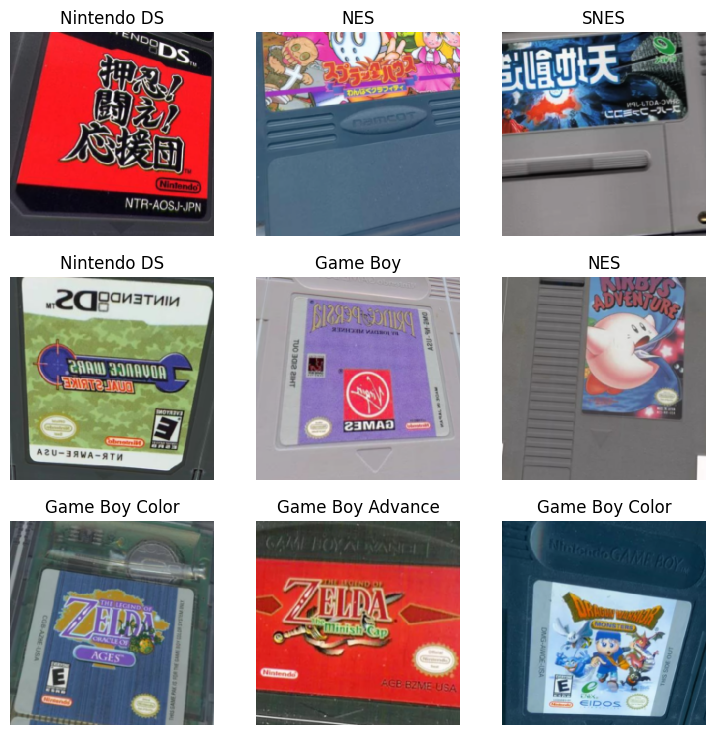

In [28]:
dls = ImageDataLoaders.from_folder(
    DATA_DIR, 
    item_tfms=Resize(480), 
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls.show_batch()

In [29]:
f1_score = F1Score(average='macro')
learn = vision_learner(dls, resnet34, metrics=[error_rate, f1_score])
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.371866,3.038861,0.753623,00:36


epoch,train_loss,valid_loss,error_rate,time
0,2.128707,1.879031,0.608696,01:26
1,1.595582,0.997153,0.304348,01:37
2,1.176943,0.581544,0.144928,01:39
3,0.953840,0.414006,0.144928,01:38


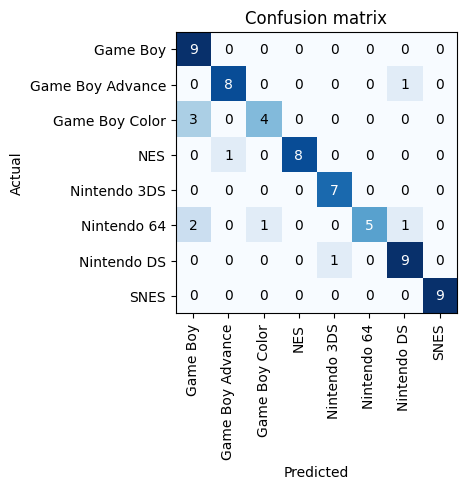

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

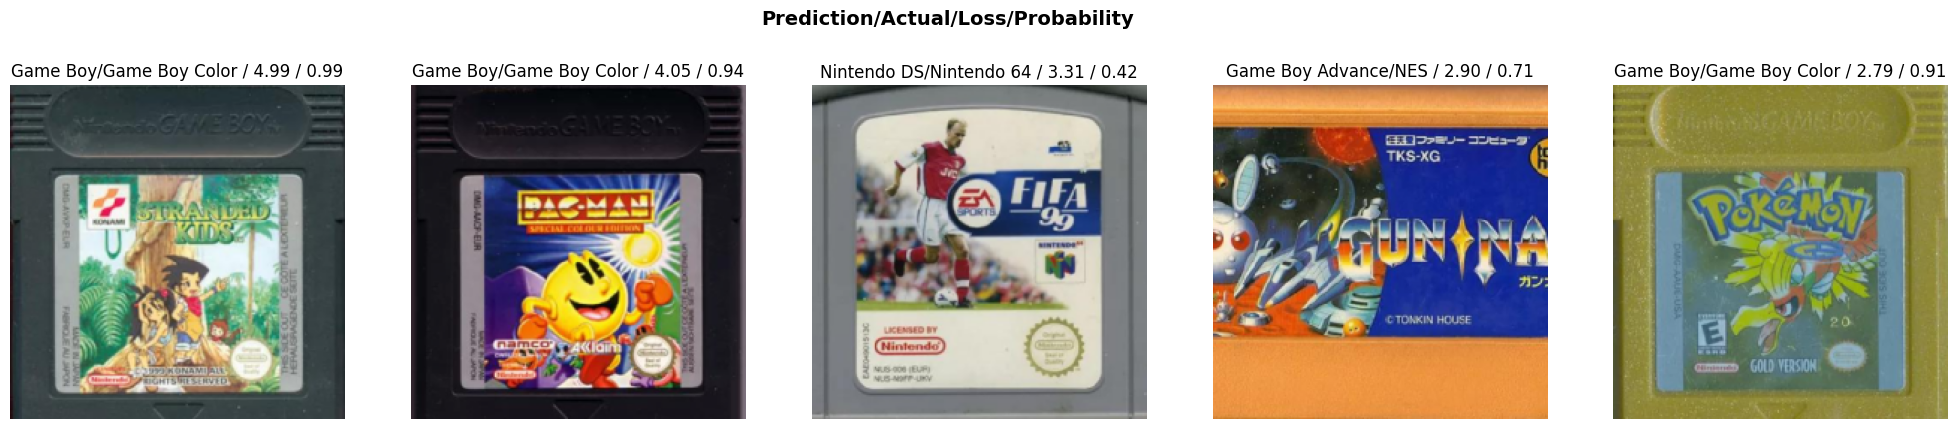

In [33]:
interp.plot_top_losses(5, nrows=1, figsize=(25, 5))

In [34]:
import ipywidgets as widgets

upload = widgets.FileUpload()
display(upload)

FileUpload(value=(), description='Upload')

In [ ]:
img = Image.create(upload.data[-1])
img.show()

In [ ]:
learn.predict(img)
pred, index, probs = learn.predict(img)

print(f'This is an image of {pred}')
print(f'Probability: {probs[index]:.3f}')

In [35]:
learn.export(OUTPUT_DIR/'classifier.pkl')